# Auto\-Encodeur Variationnel



## Set up

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

PyTorch version: 2.1.0+cu121


In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [3]:
WIDTH, HEIGHT = 28, 28
EPOCHS: int = 20
BATCH_SIZE: int = 32
latent_dim = 2

In [4]:
resources_folder = 'resources/classification'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)

data = [np.load(os.path.join(resources_folder, 'full_numpy_bitmap_'+class_name+'.npy')) for class_name in classes]
print(f'loaded numpy bitmaps, {nb_classes} classes')

loaded numpy bitmaps, 8 classes


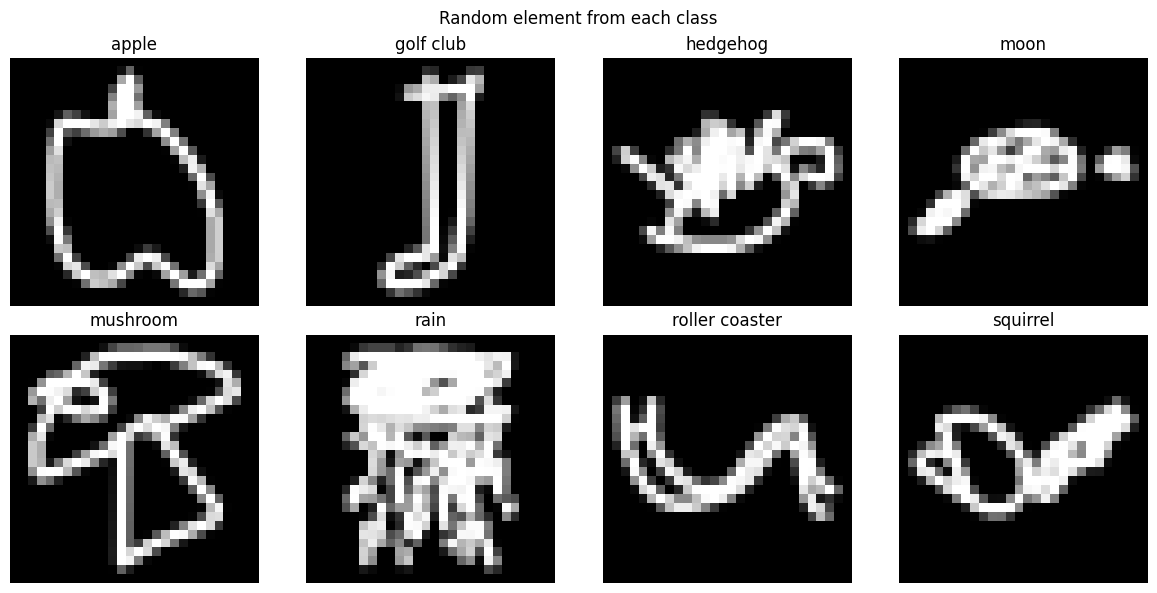

In [5]:
to_plot = []

for class_data in data:
    array = random.choice(class_data).reshape(WIDTH, HEIGHT)
    to_plot.append(array)

num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i in range(nb_classes):
    row_index = i // num_cols
    col_index = i % num_cols
    axes[row_index, col_index].imshow(to_plot[i], cmap='gray')
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(classes[i])

plt.tight_layout()
plt.suptitle('Random element from each class')

plt.subplots_adjust(top=0.9)

plt.show()

## Dataset creation

In [6]:
from dataset_creation.DataManager import DataManager

split = 0.8
data_manager = DataManager()

training_data, training_labels, validation_data, validation_labels = data_manager.split_data(split, data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')

training dataset size : 927239
validation dataset size : 231814


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

In [8]:
from dataset_creation.GraysacleDataset import GrayscaleDataset

len_subset = 2000

training_set = GrayscaleDataset(data=shuffled_training_data[:len_subset], labels=shuffled_training_labels[:len_subset],
                             width=WIDTH, height=HEIGHT, reshape=False, normalize=True)
validation_set = GrayscaleDataset(data=shuffled_validation_data[:len_subset], labels=shuffled_validation_labels[:len_subset],
                             width=WIDTH, height=HEIGHT, reshape=False, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)

## Variationel Autoencoder class



In [41]:
class VarAutoencoder(nn.Module):
    def __init__(self, layer_sizes=[(WIDTH * HEIGHT), 128, 64, 32]):
        super(VarAutoencoder, self).__init__()
        self.architecture = layer_sizes
        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Add encoder layers
        for i in range(len(layer_sizes) - 1):
            self.encoder.add_module(f"encoder_{i}", nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                self.encoder.add_module(f"encoder_relu_{i}", nn.ReLU())
                self.encoder.add_module(f"encoder_dropout_{i}", nn.Dropout(0.3))
                self.encoder.add_module(f"encoder_batchnorm_{i}", nn.BatchNorm1d(layer_sizes[i+1]))

        self.mu = nn.Linear(layer_sizes[-1], latent_dim)
        self.logvar = nn.Linear(layer_sizes[-1], latent_dim)

        # Add decoder layers
        
        self.decoder.add_module(f"decoder_latent", nn.Linear(latent_dim, layer_sizes[-1]))
        for i in range(len(layer_sizes) - 1, 0, -1):
            self.decoder.add_module(f"decoder_{i}", nn.Linear(layer_sizes[i], layer_sizes[i-1]))
            if i > 1:
                self.decoder.add_module(f"decoder_relu_{i}", nn.ReLU())
                self.decoder.add_module(f"encoder_dropout_{i}", nn.Dropout(0.3))
                self.decoder.add_module(f"encoder_batchnorm_{i}", nn.BatchNorm1d(layer_sizes[i+1]))

        self.decoder.add_module("decoder_sigmoid", nn.Sigmoid())

    def sampling(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, WIDTH * HEIGHT)
        encoded = self.encoder(x)
        
        mu = self.mu(encoded)
        logvar = self.logvar(encoded)
        
        z = self.sampling(mu, logvar)
        
        decoded = self.decoder(z)
        
        return mu, logvar, decoded

    def print_model(self):
        print(self.encoder)
        print(self.decoder)

## Try with simple model

In [42]:
def vae_loss(mu, logvar, decoded, inputs):
    # Fonction de perte de reconstruction (MSE dans ce cas)
    reconstruction_loss = F.mse_loss(decoded, inputs.view(-1, WIDTH * HEIGHT), reduction='sum')

    # KL divergence entre la distribution latente et une distribution normale
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combinaison des deux termes de perte
    return reconstruction_loss + beta * kl_divergence

In [43]:
architecture_1 = [WIDTH * HEIGHT, WIDTH * HEIGHT // 3]
autoencoder_model = VarAutoencoder(architecture_1).to(device)

# Define loss function and optimizer
beta = 1.0
criterion = vae_loss
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

In [44]:
# Print architecture 
autoencoder_model.print_model()

# Compression factor 
print(f'Compression factor: {WIDTH * HEIGHT / architecture_1[-1]}')

Sequential(
  (encoder_0): Linear(in_features=784, out_features=261, bias=True)
)
Sequential(
  (decoder_latent): Linear(in_features=2, out_features=261, bias=True)
  (decoder_1): Linear(in_features=261, out_features=784, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 3.003831417624521


In [64]:
def train_autoencoder(autoencoder_model, train_loader: DataLoader, valid_loader: DataLoader, criterion, optimizer, num_epochs):
    train_psnr_values = []
    train_ssim_values = []

    validation_psnr_values = []
    validation_ssim_values = []

    train_loss_values = []
    validation_loss_values = []

    for epoch in range(num_epochs):
        # Train by batch of images
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            mu, logvar, decoded = autoencoder_model.forward(inputs)
            loss = criterion(mu, logvar, decoded, inputs)

            # Backward pass
            loss.backward()
            optimizer.step()

        # Train loss
        train_loss_values.append(loss.item())

        # loop on validation to compute validation loss
        for data in valid_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            
            # Forward pass
            mu, logvar, decoded = autoencoder_model.forward(inputs)
            loss = criterion(mu, logvar, decoded, inputs)

        validation_loss_values.append(loss.item())

        # Calculate PSNR and SSIM for train and test sets
        train_psnr = 0
        train_ssim = 0
        validation_psnr = 0
        validation_ssim = 0

        nb_train_images = 0
        nb_valid_images = 0
        
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            for i in range(inputs.size(0)):
                nb_train_images+=1
                img_as_tensor = inputs[i]

                _, _, decoded = autoencoder_model(img_as_tensor)

                decoded = decoded.squeeze()

                image_matrix = img_as_tensor.cpu().detach().numpy()
                decoded_matrix = decoded.cpu().detach().numpy()

                train_psnr += psnr(image_matrix, decoded_matrix)
                train_ssim += ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())

        for data in valid_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            for i in range(inputs.size(0)):
                nb_valid_images+=1
                img_as_tensor = inputs[i]

                _, _, decoded = autoencoder_model(img_as_tensor)

                decoded = decoded.squeeze()

                image_matrix = img_as_tensor.cpu().detach().numpy()
                decoded_matrix = decoded.cpu().detach().numpy()

                validation_psnr += psnr(image_matrix, decoded_matrix)
                validation_ssim += ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())

        train_psnr /= nb_train_images
        train_ssim /= nb_train_images
        validation_psnr /= nb_valid_images
        validation_ssim /= nb_valid_images

        train_psnr_values.append(train_psnr)
        train_ssim_values.append(train_ssim)
        validation_psnr_values.append(validation_psnr)
        validation_ssim_values.append(validation_ssim)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss_values[-1]:.4f}, Test Loss {validation_loss_values[-1]:.4f}, ', end = "")
        print(f'Train PSNR: {train_psnr:.4f}, Train SSIM: {train_ssim:.4f}, Validation PSNR: {validation_psnr:.4f}, Validation SSIM: {validation_ssim:.4f}')

    return train_loss_values, validation_loss_values, train_psnr_values, train_ssim_values, validation_psnr_values, validation_ssim_values

In [ ]:
# Call the function
num_epochs = 40
train_loss_values, validation_loss_values, train_psnr_values, train_ssim_values, validation_psnr_values, validation_ssim_values \
    = train_autoencoder(autoencoder_model, training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs)

Epoch [1/40], Loss: 1168.2406, Test Loss 1014.8774, Train PSNR: 11.3583, Train SSIM: 0.0982, Validation PSNR: 11.3455, Validation SSIM: 0.0948
Epoch [2/40], Loss: 1048.1857, Test Loss 992.4682, Train PSNR: 11.3214, Train SSIM: 0.0978, Validation PSNR: 11.3116, Validation SSIM: 0.0936
Epoch [3/40], Loss: 946.0214, Test Loss 1055.7871, Train PSNR: 11.3807, Train SSIM: 0.0959, Validation PSNR: 11.3642, Validation SSIM: 0.0918
Epoch [4/40], Loss: 1056.7847, Test Loss 1034.0320, Train PSNR: 11.3462, Train SSIM: 0.1029, Validation PSNR: 11.3302, Validation SSIM: 0.0995
Epoch [5/40], Loss: 977.7473, Test Loss 1026.6211, Train PSNR: 11.3765, Train SSIM: 0.1021, Validation PSNR: 11.3597, Validation SSIM: 0.0976
Epoch [6/40], Loss: 942.2488, Test Loss 1075.9319, Train PSNR: 11.3516, Train SSIM: 0.1021, Validation PSNR: 11.3428, Validation SSIM: 0.0983
Epoch [7/40], Loss: 946.8808, Test Loss 1110.6565, Train PSNR: 11.3833, Train SSIM: 0.0981, Validation PSNR: 11.3671, Validation SSIM: 0.0938
Epoc

In [ ]:
# Define a function to plot Train and Test Loss, PSNR and SSIM values
def plot_psnr_ssim(train_loss_values, test_loss_values, train_psnr_values, test_psnr_values, train_ssim_values, test_ssim_values):
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].plot(train_loss_values, label='Train Loss')
    axes[0].plot(test_loss_values, label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_psnr_values, label='Train PSNR')
    axes[1].plot(test_psnr_values, label='Validation PSNR')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('PSNR')
    axes[1].legend()

    axes[2].plot(train_ssim_values, label='Train SSIM')
    axes[2].plot(test_ssim_values, label='Validation SSIM')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('SSIM')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Call the function
plot_psnr_ssim(train_loss_values, validation_loss_values, train_psnr_values, validation_psnr_values, train_ssim_values, validation_ssim_values)

In [ ]:
# Define a function to show original and reconstructed images
def show_images(train_set, validation_set, autoencoder_model):
    num_cols = 4
    num_rows = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

    for i in range(num_cols // 2):
        # Train images
        index = random.randint(0, train_set.__len__())

        axes[0, i].imshow(train_set.get_image_2d(index), cmap='gray')
        axes[0, i].set_title(f"Train original {train_set[index][1]}")
        axes[0, i].axis('off')

        # Reconstructed images
        train_tensor = torch.from_numpy(train_set[index][0]).to(device)
        encoded, decoded = autoencoder_model(train_tensor)
        decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

        axes[1, i].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
        axes[1, i].set_title(f"Train reconstructed {classes[train_set[index][1]]}")
        axes[1, i].axis('off')
    
    for i in range(num_cols // 2, num_cols):
        # Test images
        index = random.randint(0, validation_set.__len__())

        axes[0, i].imshow(validation_set.get_image_2d(index), cmap='gray')
        axes[0, i].set_title(f"Validation original, {validation_set[index][1]}")
        axes[0, i].axis('off')

        # Reconstructed images
        validation_tensor = torch.from_numpy(validation_set[index][0]).to(device)
        encoded, decoded = autoencoder_model(validation_tensor)
        decoded = decoded.view(-1, HEIGHT, WIDTH)

        axes[1, i].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
        axes[1, i].set_title(f"Validation reconstructed {classes[validation_set[index][1]]}")
        axes[1, i].axis('off')

    plt.show()

In [ ]:
# Call the function
show_images(training_set, validation_set, autoencoder_model)

In [ ]:
# Show image with the lowest psnr then ssim in the test set
def return_lowest_image_index_psnr_ssim(dataset, autoencoder_model):
    lowest_psnr = 100
    lowest_ssim = 100
    lowest_psnr_index = 0
    lowest_ssim_index = 0

    for batch in dataset:
        test_images, test_labels = batch
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        _, decoded = autoencoder_model(test_images)

        decoded_matrices = decoded.cpu().detach().numpy()
        test_images_matrices = test_images.cpu().detach().numpy()

        for i in range(test_images.size(0)):
            image_matrix = test_images_matrices[i]
            decoded_matrix = decoded_matrices[i]

            psnr_value = psnr(image_matrix, decoded_matrix)
            ssim_value = ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())
            
            if psnr_value < lowest_psnr:
                lowest_psnr = psnr_value
                lowest_psnr_index = i

            if ssim_value < lowest_ssim:
                lowest_ssim = ssim_value
                lowest_ssim_index = i

    return [lowest_psnr_index, lowest_psnr], [lowest_ssim_index, lowest_ssim]

In [ ]:
CHECK_BACTH_SIZE = 8000

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [ ]:
lowest_psnr, lowest_ssim = return_lowest_image_index_psnr_ssim(validation_check_dataloader, autoencoder_model)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

In [ ]:
# Show image with the lowest psnr and ssim compared to their original the test set on same plot
def show_lowest_psnr_ssim_image(image_set, autoencoder_model, lowest_psnr, lowest_ssim):
    lowest_psnr_index, psnr  = lowest_psnr
    psnr_image_label = classes[image_set[lowest_psnr_index][1]]

    lowest_ssim_index, ssim  = lowest_ssim
    ssim_image_label = classes[image_set[lowest_ssim_index][1]]

    fig, axes = plt.subplots(2, 2, figsize=(7, 6))

    # PSNR image
    axes[0, 0].imshow(image_set.get_image_2d(lowest_psnr_index), cmap='gray')
    axes[0, 0].set_title("Original : " + psnr_image_label)
    axes[0, 0].axis('off')

    psnr_image_tensor = torch.from_numpy(image_set[lowest_psnr_index][0]).to(device)
    _, decoded = autoencoder_model(psnr_image_tensor)
    decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

    axes[0, 1].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
    axes[0, 1].set_title(f"Reconstructed : {psnr_image_label}, PSNR: {psnr:.4f}")
    axes[0, 1].axis('off')

    # SSIM image
    axes[1, 0].imshow(image_set.get_image_2d(lowest_ssim_index), cmap='gray')
    axes[1, 0].set_title("Original : " + ssim_image_label)
    axes[1, 0].axis('off')

    ssim_image_tensor = torch.from_numpy(image_set[lowest_ssim_index][0]).to(device)
    _, decoded = autoencoder_model(ssim_image_tensor)
    decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

    axes[1, 1].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
    axes[1, 1].set_title(f"Reconstructed : {ssim_image_label}, SSIM: {ssim:.4f}")
    axes[1, 1].axis('off')

    plt.show()


In [ ]:
# Call the function
show_lowest_psnr_ssim_image(validation_set, autoencoder_model, lowest_psnr, lowest_ssim)

## Try with a different model architecture

In [ ]:
layers = [WIDTH * HEIGHT, WIDTH * HEIGHT]
autocoder_2 = Autoencoder(layers).to(device)

# Define loss function and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autocoder_2.parameters(), lr=0.001)

# Print architecture
autocoder_2.print_model()

# Compression factor
print(f'Compression factor: {WIDTH * HEIGHT / autocoder_2.architecture[-1]}')

In [ ]:
# Call the function
num_epochs = 40

train_loss_values, validation_loss_values, train_psnr_values, train_ssim_values, validation_psnr_values, validation_ssim_values \
    = train_autoencoder(autocoder_2, training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs)

In [ ]:
plot_psnr_ssim(train_loss_values, validation_loss_values, train_psnr_values, validation_psnr_values, train_ssim_values, validation_ssim_values)

In [ ]:
show_images(training_set, validation_set, autocoder_2)

In [ ]:
lowest_psnr, lowest_ssim = return_lowest_image_index_psnr_ssim(validation_check_dataloader, autocoder_2)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

show_lowest_psnr_ssim_image(validation_set, autocoder_2, lowest_psnr, lowest_ssim)

## Try with resnet18 architecture

In [ ]:
# Use pretrained model

# Load pretrained model

pretrained_model = models.resnet18(pretrained=True)
pretrained_model = pretrained_model.to(device)

# Print pretrained model architecture
print(pretrained_model)

# Freeze all layers

for param in pretrained_model.parameters():
    param.requires_grad = False

# Add custom layers

pretrained_model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, nb_classes)
)

# Print new model architecture
print(pretrained_model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001)


In [ ]:
# Define a function to train the model
def train_pretained_model():
    pass

## Generating images

In [ ]:
def return_classes_mean_encoded_vector(model, images_set):
    mean_encoded_vectors = []
    mean_vectors_size = model.architecture[-1]
    count_classes_number = [0] * nb_classes

    for i in range(nb_classes):
        mean_encoded_vectors.append(np.zeros(mean_vectors_size))

    for batch in images_set:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        encoded, decoded = model(images)
        encoded_np = encoded.cpu().detach().numpy()

        for i in range(len(images)):
            mean_encoded_vectors[labels[i]] += encoded_np[i]

        count_classes_number[labels[i]] += 1
            
    for i in range(nb_classes):
        mean_encoded_vectors[i] = mean_encoded_vectors[i] / count_classes_number[i] / 255.0

        print(f'Class {classes[i]} range of mean encoded vector: [{mean_encoded_vectors[i].min()}, {mean_encoded_vectors[i].max()}]')

    return mean_encoded_vectors

def generated_images_for_mean_vector(mean_encoded_vectors, model):
    generated_images = []

    decoder = model.decoder
    for i in range(nb_classes):
        mean_vector = mean_encoded_vectors[i]
        double_mean_vector = np.array([mean_vector]).astype(np.float32)
        mean_vector_torch = torch.from_numpy(double_mean_vector).to(device)

        decoded = decoder(mean_vector_torch)

        generated_images.append(decoded.cpu().detach().numpy()[0].reshape(HEIGHT, WIDTH))

    return generated_images

def show_generated_images(generated_images):
    num_cols = 4
    num_rows = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    for i in range(nb_classes):
        row_index = i // num_cols
        col_index = i % num_cols
        axes[row_index, col_index].imshow(generated_images[i], cmap='gray')
        axes[row_index, col_index].axis('off')
        axes[row_index, col_index].set_title(classes[i])

    plt.tight_layout()
    plt.suptitle('Generated images')

    plt.subplots_adjust(top=0.9)

    plt.show()

In [ ]:
def create_alternative_version(mean_vector, weight=0.1):
    alternative_mean_vector = mean_vector.copy()
    # Vector is composed of float values 
    # use gaussian distribution to generate altertivate vector based on mean one

    for i in range(len(mean_vector)):
        alternative_mean_vector[i] = np.random.normal(mean_vector[i], weight)
    
    return alternative_mean_vector

In [ ]:
mean_encoded_vectors = return_classes_mean_encoded_vector(autoencoder_model, training_loaded_set)
generated_images = generated_images_for_mean_vector(mean_encoded_vectors, autoencoder_model)
show_generated_images(generated_images)

In [ ]:
alternative_versions = []
for mean_encoded_vector in mean_encoded_vectors:
    alternative_versions.append(create_alternative_version(mean_encoded_vector, 0.05))

alternative_generated_version = generated_images_for_mean_vector(alternative_versions, autoencoder_model)
show_generated_images(alternative_generated_version)

In [ ]:
mean_encoded_vectors = return_classes_mean_encoded_vector(autoencoder_model, training_loaded_set)
generated_images = generated_images_for_mean_vector(mean_encoded_vectors, autoencoder_model)
show_generated_images(generated_images)

In [ ]:
alternative_versions = []
for mean_encoded_vector in mean_encoded_vectors:
    alternative_versions.append(create_alternative_version(mean_encoded_vector, 0.05))

alternative_generated_version = generated_images_for_mean_vector(alternative_versions, autoencoder_model)
show_generated_images(alternative_generated_version)